# Traffic Sign Recognition

## Dataset loading and exploration

In [ ]:
# Imports
import pickle
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import math
from sklearn.utils import shuffle
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler
from keras.optimizers import SGD
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

Load our dataset

In [2]:
# Show plots inline notebook
%matplotlib inline

# Location of the dataset
training_file = 'dataset/train.p'
validation_file= 'dataset/valid.p'
testing_file = 'dataset/test.p'

# Open the files
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Save the features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Unique classes/labels in the dataset
n_classes = len(np.unique(y_train))

# Make one hot targets
y_train_hot = to_categorical(y_train, num_classes=n_classes)
y_valid_hot = to_categorical(y_valid, num_classes=n_classes)
y_test_hot = to_categorical(y_test, num_classes=n_classes)

print("Traffic Sign Dataset loaded!")

Traffic Sign Dataset loaded!


Basic Summary of the Data Set Using Numpy

In [3]:
# Number of training examples
n_train = len(y_train)
# Number of validation examples.
n_valid = len(y_valid)
# Number of testing examples.
n_test = len(y_test)

# Shape of a traffic sign image
image_shape = np.shape(X_train[0])

# Print out the results
print("Number of training examples = {}".format(n_train))
print ("Number of validation examples = {}".format(n_valid))
print ("Percentage of validation examples: {:2.2f}%".format((n_valid/(n_train*1.0))*100))
print("Number of testing examples = {}".format(n_test))
print("Image data shape = {}".format(X_train[0].shape))
print("Number of classes = {}".format(n_classes))

Number of training examples = 34799
Number of validation examples = 4410
Percentage of validation examples: 12.67%
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Print out a table with sign names, class ID and counts for better identification

In [4]:
data_pd = pd.read_csv('dataset/signnames.csv')
_, class_counts = np.unique(y_train, return_counts = True)
data_pd['Counts'] = class_counts
print(data_pd)

    ClassId                                           SignName  Counts
0         0                               Speed limit (20km/h)     180
1         1                               Speed limit (30km/h)    1980
2         2                               Speed limit (50km/h)    2010
3         3                               Speed limit (60km/h)    1260
4         4                               Speed limit (70km/h)    1770
5         5                               Speed limit (80km/h)    1650
6         6                        End of speed limit (80km/h)     360
7         7                              Speed limit (100km/h)    1290
8         8                              Speed limit (120km/h)    1260
9         9                                         No passing    1320
10       10       No passing for vehicles over 3.5 metric tons    1800
11       11              Right-of-way at the next intersection    1170
12       12                                      Priority road    1890
13    

Display 100 random traffic signs, together with their label below

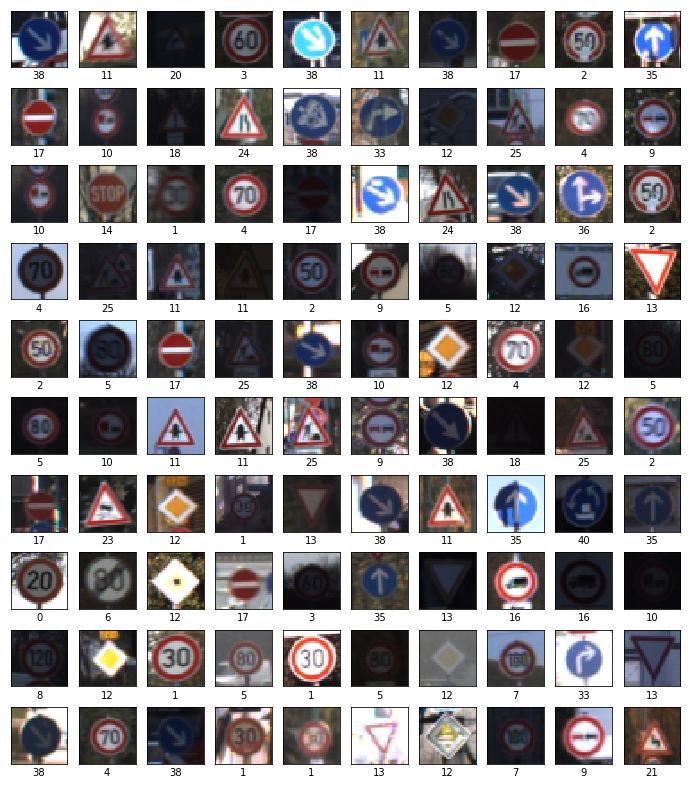

In [5]:
def showRandomImages(gray = False):
    fig = plt.figure(figsize=(12, 14))
    for i in range(0, 100):
        number = np.random.randint(0, len(X_train))
        axis = fig.add_subplot(10,10,i+1)
        axis.set_xlabel(y_train[number])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if not gray:
            axis.imshow(X_train[number])
        else:
            axis.imshow(X_train[number], cmap='gray')
    plt.show()

showRandomImages()

Show a distribution of the training and testing data in the set, counts per class over class ID

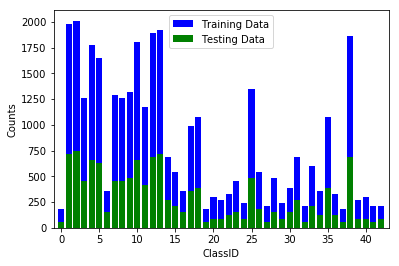

In [7]:
def showDistribution():
    _, training_counts = np.unique(y_train, return_counts = True)
    _, test_counts = np.unique(y_test, return_counts = True)
    plt.bar( np.arange( 43 ), training_counts, align='center',  color='b', label='Training Data')
    plt.bar( np.arange( 43 ), test_counts, align='center', color='g', label='Testing Data')
    plt.xlabel('ClassID')
    plt.ylabel('Counts')
    plt.xlim([-1, 43])
    plt.legend()
    plt.show()
    
showDistribution()

Convert images to grayscale, as color information is not really required

In [8]:
def convertToGray(image_data):
    image_data = cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY)
    image_data = np.reshape(image_data, (32, 32, 1))
    return image_data

X_train = np.array([convertToGray(X_train[i]) for i in range(len(X_train))])
X_valid = np.array([convertToGray(X_valid[i]) for i in range(len(X_valid))])
X_test = np.array([convertToGray(X_test[i]) for i in range(len(X_test))])
print("Images converted to grayscale!")

Images converted to grayscale!


Calculate the weight influence compared to the majority class

In [9]:
def get_class_weights(y):
    unique, counts = np.unique(y, return_counts=True)
    majority = max(counts)
    return  {cls: float(majority/count) for cls, count in zip(unique, counts)}

class_weights = get_class_weights(y_train)
print(class_weights)

{0: 11.166666666666666, 1: 1.0151515151515151, 2: 1.0, 3: 1.5952380952380953, 4: 1.1355932203389831, 5: 1.2181818181818183, 6: 5.583333333333333, 7: 1.558139534883721, 8: 1.5952380952380953, 9: 1.5227272727272727, 10: 1.1166666666666667, 11: 1.7179487179487178, 12: 1.0634920634920635, 13: 1.046875, 14: 2.9130434782608696, 15: 3.7222222222222223, 16: 5.583333333333333, 17: 2.0303030303030303, 18: 1.8611111111111112, 19: 11.166666666666666, 20: 6.7, 21: 7.444444444444445, 22: 6.090909090909091, 23: 4.466666666666667, 24: 8.375, 25: 1.488888888888889, 26: 3.7222222222222223, 27: 9.571428571428571, 28: 4.1875, 29: 8.375, 30: 5.153846153846154, 31: 2.9130434782608696, 32: 9.571428571428571, 33: 3.35559265442404, 34: 5.583333333333333, 35: 1.8611111111111112, 36: 6.090909090909091, 37: 11.166666666666666, 38: 1.0806451612903225, 39: 7.444444444444445, 40: 6.7, 41: 9.571428571428571, 42: 9.571428571428571}


## Model Architecture

Do some data augmentation by changing brightness, rotation, translation and transformation

In [10]:
# Data generator for image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False, 
    featurewise_std_normalization=False, 
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

Define our model in Keras and show an overview

In [11]:
def create_model():
    model = Sequential()
    
    # 1st conv layer with 32 filter, 3x3 each, no dropout
    model.add(Conv2D(32, (3, 3), activation='relu', name='conv1', input_shape=(32, 32, 1), padding="same"))  

    # 2nd conv layer with 32 filter, 3x3 each, 20% dropout
    model.add(Conv2D(32, (3, 3), activation='relu', name='conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # 3rd conv layer with 64 filter, 3x3 each, no dropout
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv3',padding="same"))
    
    # 4rd conv layer with 64 filter, 3x3 each, 20% dropout
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv4'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # 5rd conv layer with 128 filter, 3x3 each, no dropout
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv5',padding="same"))
    
    # 6rd conv layer with 128 filter, 3x3 each, 20% dropout
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv6'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # We flatten the conv layer
    model.add(Flatten())
    
    # Fully connected layer with 512 neurons and 50% dropout
    model.add(Dense(512, activation="relu",name="dense1")) 
    model.add(Dropout(0.5))

    # This is our output layer with softmax
    model.add(Dense(43 ,activation="softmax", name="dense2"))
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 15, 15, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

## Train, Validate and Test the Model

Train our model for 100 epochs maximum

In [12]:
# Our training data generator
train_generator = train_datagen.flow(X_train, y_train_hot, batch_size=128)

# Out validation data generator
validation_generator = test_datagen.flow(X_valid, y_valid_hot, batch_size=128)

# Let's train the model using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Early stopping, if progress on validation data does not improve after 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

# Our learning rate scheduler
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

# Train our model
history = model.fit_generator(train_generator, steps_per_epoch=len(X_train) / 128, epochs=100,
        validation_data=validation_generator, validation_steps=len(X_valid) / 128, 
        class_weight=class_weights, verbose=2, callbacks=[LearningRateScheduler(lr_schedule), early_stop])

# Save the model to file
model.save_weights('./dataset/model.h5')

# Print message
print("Model trained!")

Epoch 1/100
8s - loss: 9.2157 - acc: 0.0342 - val_loss: 3.7174 - val_acc: 0.0245
Epoch 2/100
7s - loss: 7.5655 - acc: 0.1409 - val_loss: 1.8257 - val_acc: 0.4322
Epoch 3/100
7s - loss: 3.9929 - acc: 0.4819 - val_loss: 0.6621 - val_acc: 0.7891
Epoch 4/100
7s - loss: 2.2233 - acc: 0.6818 - val_loss: 0.2931 - val_acc: 0.9156
Epoch 5/100
7s - loss: 1.5782 - acc: 0.7758 - val_loss: 0.2719 - val_acc: 0.9186
Epoch 6/100
7s - loss: 1.2520 - acc: 0.8167 - val_loss: 0.1919 - val_acc: 0.9460
Epoch 7/100
7s - loss: 1.0690 - acc: 0.8428 - val_loss: 0.2018 - val_acc: 0.9540
Epoch 8/100
7s - loss: 0.9167 - acc: 0.8673 - val_loss: 0.1146 - val_acc: 0.9687
Epoch 9/100
7s - loss: 0.7943 - acc: 0.8837 - val_loss: 0.1095 - val_acc: 0.9694
Epoch 10/100
7s - loss: 0.7053 - acc: 0.8955 - val_loss: 0.1131 - val_acc: 0.9669
Epoch 11/100
8s - loss: 0.4951 - acc: 0.9266 - val_loss: 0.0781 - val_acc: 0.9787
Epoch 12/100
7s - loss: 0.3668 - acc: 0.9408 - val_loss: 0.0741 - val_acc: 0.9803
Epoch 13/100
7s - loss: 0

Show loss and accuracy for training and validation data

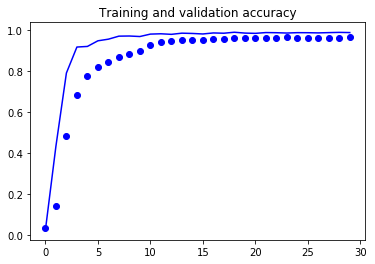

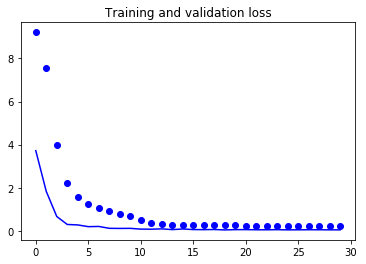

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

Evaluate the model on the test data

In [14]:
# Out validation data generator
test_generator = test_datagen.flow(X_test, y_test_hot, batch_size=128)

# Calculate score
score = model.evaluate_generator(test_generator, len(X_test) / 128)
print("Test loss is: " + str(score[0]))
print("Test accuracy is: " + str(score[1]))

Test loss is: 0.0887654530629
Test accuracy is: 0.9768804432



## Test model on new images

Load the network

In [15]:
model.load_weights('./dataset/model.h5')
print("Network loaded!")

Network loaded!


Show the images we want to use for our test

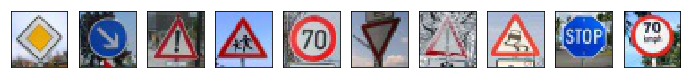

In [16]:
# Name of the five test images
imageNames = ['S1.jpg', 'S2.jpg', 'S3.jpg', 'S4.jpg', 'S5.jpg', 'S6.jpg', 'S7.jpg', 'S8.jpg', 'S9.jpg', 'S10.jpg']

def showTestImages(labels = None):
    fig = plt.figure(figsize=(12, 14))
    for i in range(0, len(imageNames)):
        axis = fig.add_subplot(10,10,i+1)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        
        # Show labels if provided
        if labels is not None:
            axis.set_xlabel(labels[i])
        # Load image from file
        img = mpimg.imread('test_images/' + imageNames[i])
        # Show it
        axis.imshow(img)

    # Show the plot
    plt.show()

showTestImages()

Store the image pixels and convert the image to grayscale

In [17]:
# Store the image pixels here
images = []
for i in range(0, len(imageNames)):
    img = mpimg.imread('test_images/' + imageNames[i])
    images.append(img)
    
# Store the true classes here
true_classes = np.array([12, 38, 18, 28, 4, 13, 18, 23, 14, 4])

# Convert the new images to grayscale
images = np.array([convertToGray(images[i]) for i in range(len(images))])

# Normalize
images = (images / 255.0).astype(np.float32)

print("Images converted to grayscale and normalized!")

Images converted to grayscale and normalized!


Predict the sign type for each image and the probabilities

In [18]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

# Predict classes and probabilities
predicted_classes = model.predict_classes(images, verbose=0)
prob_classes = model.predict(images, verbose=0)
print("Prediction finished!")
    
# Print out accuracy
test_accuracy = (np.sum(predicted_classes == true_classes) / len(true_classes)) * 100.0
print("Test Accuracy: {:2.2f}%".format(test_accuracy))

Prediction finished!
Test Accuracy: 90.00%


Show the test images with their predicted labels

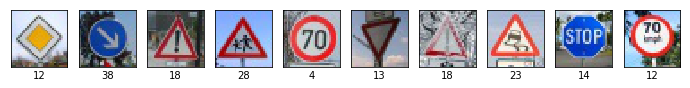

In [19]:
showTestImages(predicted_classes)

Compare what the real classes are

In [20]:
for i in range(0,len(imageNames)):
    print("Image {} - Predicted class =  {}, true class = {}".format(i+1, predicted_classes[i], true_classes[i]))

Image 1 - Predicted class =  12, true class = 12
Image 2 - Predicted class =  38, true class = 38
Image 3 - Predicted class =  18, true class = 18
Image 4 - Predicted class =  28, true class = 28
Image 5 - Predicted class =  4, true class = 4
Image 6 - Predicted class =  13, true class = 13
Image 7 - Predicted class =  18, true class = 18
Image 8 - Predicted class =  23, true class = 23
Image 9 - Predicted class =  14, true class = 14
Image 10 - Predicted class =  12, true class = 4


Show the estimated classes distribution for each image

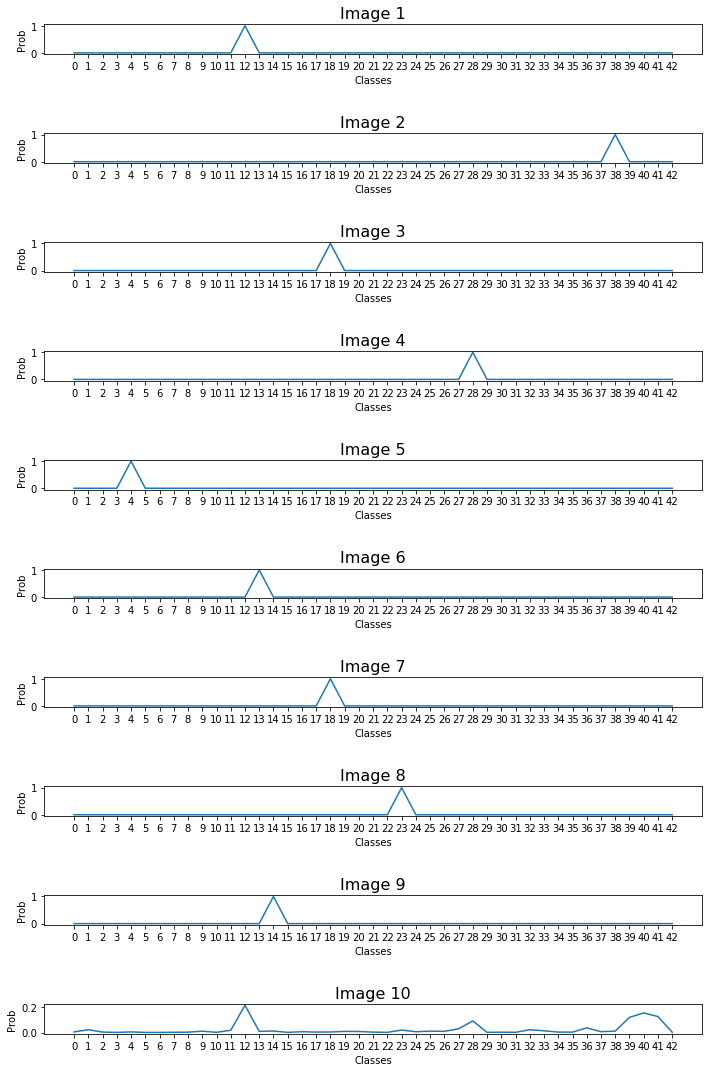

In [21]:
figure = plt.figure(figsize=(10,15))
for i in range(0,len(imageNames)):
    axis = figure.add_subplot(len(imageNames),1,i+1)
    axis.set_xlabel("Classes")
    axis.set_ylabel("Prob")
    axis.set_title("Image {}".format(i+1) , fontsize=16)
    plt.xticks(range(0,43))
    axis.plot(range(0,43),prob_classes[i])

plt.tight_layout(h_pad=3, w_pad=0)    

You can see that the network was able to classify 9 of 10 test images correctly. It failed for the last one, because it is a traffic sign from a non-german country, and the network was only trained was german signs. But in the distribution of the last sign, the network was pretty unsure what to do, with the maximum probability at around 0.2.